# First Model tuning an A into an Ä

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

In [4]:
import numpy as np
from src.data import datarenderer
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

2023-11-23 16:34:33.771430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 16:34:33.771565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 16:34:33.771712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 16:34:33.807654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Checking if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


2023-11-23 16:34:35.847246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 16:34:35.880053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 16:34:35.880099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


## Creating the Data

In [30]:
trainings_list = []

In [57]:
charset = "AÄUÜOÖ"
box_size = 64
num_glyphs = len(charset)
test_size = 0.1
batch_size = 128

In [58]:
path = os.path.join(os.pardir, "data", "processed", "filtered-fonts")
font_file_names = os.listdir(path)

np.random.seed(42)
font_file_names = np.random.permutation(font_file_names)
font_file_paths = [os.path.join(path, font_file_name) for font_file_name in font_file_names]
num_samples = len(font_file_paths)
num_samples

15820

In [59]:
num_test_samples = int(num_samples * test_size)
dataset_train = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=box_size, chars=charset, normalize=True))
dataset_test = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=box_size, chars=charset, normalize=True))

(64, 64, 6)


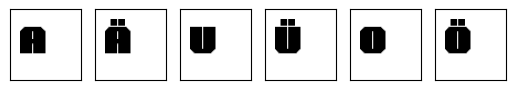

In [60]:
example = next(iter(dataset_train))
print(example.shape)

def render_charset(charset):
    fig, axs = plt.subplots(1, num_glyphs)
    for idx in range(num_glyphs):
        axs[idx].imshow(charset[:, :, idx], cmap="gray")
        axs[idx].set_xticks([])
        axs[idx].set_yticks([])
    plt.show()

render_charset(example)

In [61]:
def encode(image):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, image

In [62]:
img1, img2 = encode(example)
print(img1.shape)
print(img2.shape)

(64, 64, 6)
(64, 64, 6)


In [63]:
dataset_train = dataset_train.map(lambda image: encode(image)).shuffle(num_samples - num_test_samples).batch(batch_size)
dataset_test = dataset_test.map(lambda image: encode(image)).batch(batch_size)

In [71]:
def render_predictions(model, dataset_test, num_examples=4, figsize=(10, 10)):
    # function to plot the images: input, target and prediction
    if num_examples < 2:
        raise ValueError("num_examples must be at least 2")
    
    examples = dataset_test.take(num_examples)
    num_glyphs = next(iter(examples))[0].shape[3]

    # print(num_glyphs)

    fig, axs = plt.subplots(num_examples, 3*num_glyphs, figsize=figsize)
    for idx, (input_img, target_img) in enumerate(examples):
        prediction = model.predict(input_img, verbose=0)
        for idx2 in range(num_glyphs):
            axs[idx, 3*idx2].imshow(input_img[0, :, :, idx2], cmap="gray")
            axs[idx, 3*idx2].set_xticks([])
            axs[idx, 3*idx2].set_yticks([])
            axs[idx, 3*idx2].set_title("Input")
            axs[idx, 3*idx2+1].imshow(target_img[0, :, :, idx2], cmap="gray")
            axs[idx, 3*idx2+1].set_xticks([])
            axs[idx, 3*idx2+1].set_yticks([])
            axs[idx, 3*idx2+1].set_title("Target")
            axs[idx, 3*idx2+2].imshow(prediction[0, :, :, idx2], cmap="gray")
            axs[idx, 3*idx2+2].set_xticks([])
            axs[idx, 3*idx2+2].set_yticks([])
            axs[idx, 3*idx2+2].set_title("Prediction")
    plt.show()

In [76]:
def render_histories(trainings_list):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for idx, training in enumerate(trainings_list):
        axs[0].plot(training["history"].history["loss"], label=f"Training {idx}")
        axs[1].plot(training["history"].history["val_loss"], label=f"Training {idx}")
    axs[0].set_title("Training loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[1].set_title("Validation loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.show()

def analyze_trainings(trainings_list):
    metric_compare = "val_loss"

    idx_best_training = np.argmin([np.min(training["history"].history[metric_compare]) for training in trainings_list])
    # if this was also the last training
    if idx_best_training == len(trainings_list) - 1:
        print("###############################")
        print("Best training was the last one!")
        print("###############################")
        print("Best training was the last one!")
        print("###############################")
        print("Best training was the last one!")
        print("###############################")
        # getting the index of the second best training
        idx_compare_training = np.argmin([np.min(training["history"].history[metric_compare]) for training in trainings_list[:-1]])
    else:
        idx_compare_training = len(trainings_list) - 1

    print(f"\nThe summary of the model with the best {metric_compare} during training:")
    print(trainings_list[idx_best_training]["history"].model.summary())
    print("\nThe other parameters of the best training:")
    for key, value in trainings_list[idx_best_training].items():
        if key != "history":
            print(f"{key}: {value}")
    # plotting the training and validation loss of the best training and the training to compare
    render_histories([trainings_list[idx_best_training], trainings_list[idx_compare_training]])

In [66]:
class AutoEncoder(tf.keras.Model):

  def __init__(self, latent_dim, *args, **kwargs):
    assert isinstance(latent_dim, int)
    super().__init__(*args, **kwargs)
    self.latent_dim = latent_dim

    # Encoder
    self.encoder_reshape = layers.Reshape((box_size*box_size*num_glyphs,))
    self.encoder_fc1 = layers.Dense(512, activation="relu")
    self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

    # TODO: Decoder
    self.decoder_fc1 = layers.Dense(512, activation="relu")
    self.decoder_fc2 = layers.Dense(box_size*box_size*num_glyphs, activation="sigmoid")
    self.decoder_reshape = layers.Reshape((box_size, box_size, num_glyphs))

    self._build_graph()

  def _build_graph(self): # Just here because we want to see the output shapes in the summary.
    input_shape = (box_size, box_size, num_glyphs)
    self.build( (None,) + input_shape ) # (None, 28, 28, 1)
    inputs = tf.keras.Input(shape=input_shape)
    _ = self.call(inputs)

  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    encoded = self.encoder_reshape(x)
    encoded = self.encoder_fc1(encoded)
    encoded = self.encoder_fc2(encoded)
    return encoded

  def decode(self, z):
    decoded = self.decoder_fc1(z)
    decoded = self.decoder_fc2(decoded)
    decoded = self.decoder_reshape(decoded)
    return decoded

model = AutoEncoder(128)

model.summary()
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy"
)

Model: "auto_encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 24576)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               12583424  
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 512)               66048     
                                                                 
 dense_11 (Dense)            (None, 24576)             12607488  
                                                                 
 reshape_5 (Reshape)         (None, 64, 64, 6)         0         
                                                                 
Total params: 25322624 (96.60 MB)
Trainable params: 

In [74]:
trainings_list.append({
    "charset": charset,
    "box_size": box_size,
    "test_size": test_size,
    "batch_size": batch_size,
    "history": model.fit(
        dataset_train,
        epochs=50,
        validation_data=dataset_test
)})

Epoch 1/50


112/112 [==============================] - 3s 20ms/step - loss: 0.0555 - val_loss: 0.0690
Epoch 2/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0558 - val_loss: 0.0680
Epoch 3/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0554 - val_loss: 0.0672
Epoch 4/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0552 - val_loss: 0.0686
Epoch 5/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0551 - val_loss: 0.0679
Epoch 6/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0553 - val_loss: 0.0686
Epoch 7/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0551 - val_loss: 0.0669
Epoch 8/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0547 - val_loss: 0.0672
Epoch 9/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0546 - val_loss: 0.0676
Epoch 10/50
112/112 [==============================] - 3s 20ms/step - loss: 0.0549 - val_loss: 0.0674



The summary of the model with the best val_loss during training:
Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dense_7 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape_3 (Reshape)         (None, 64, 64, 2)         0         
                                                    

_________________________________________________________________
None

The other parameters of the best training:
charset: AÄ
box_size: 64
test_size: 0.1
batch_size: 128


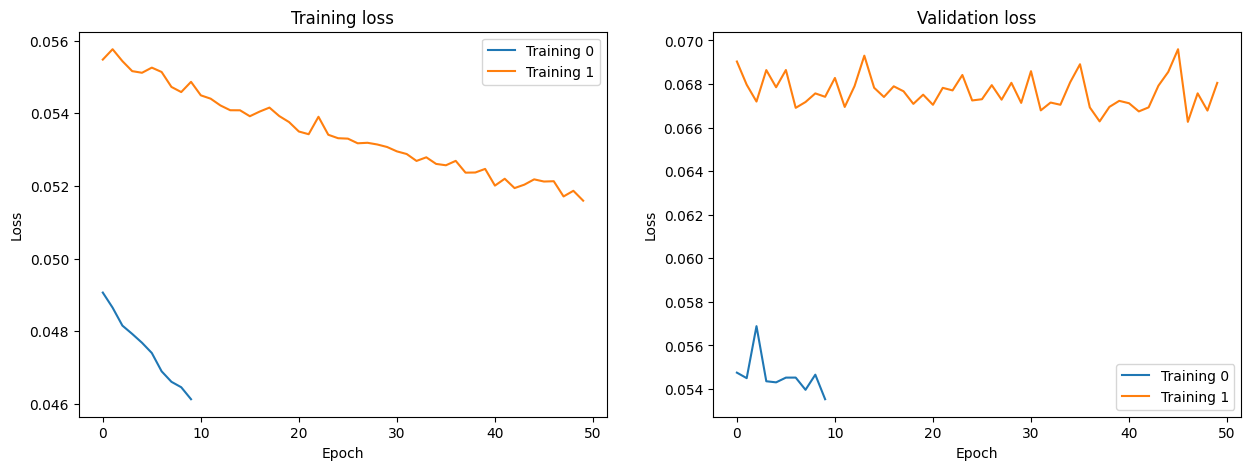

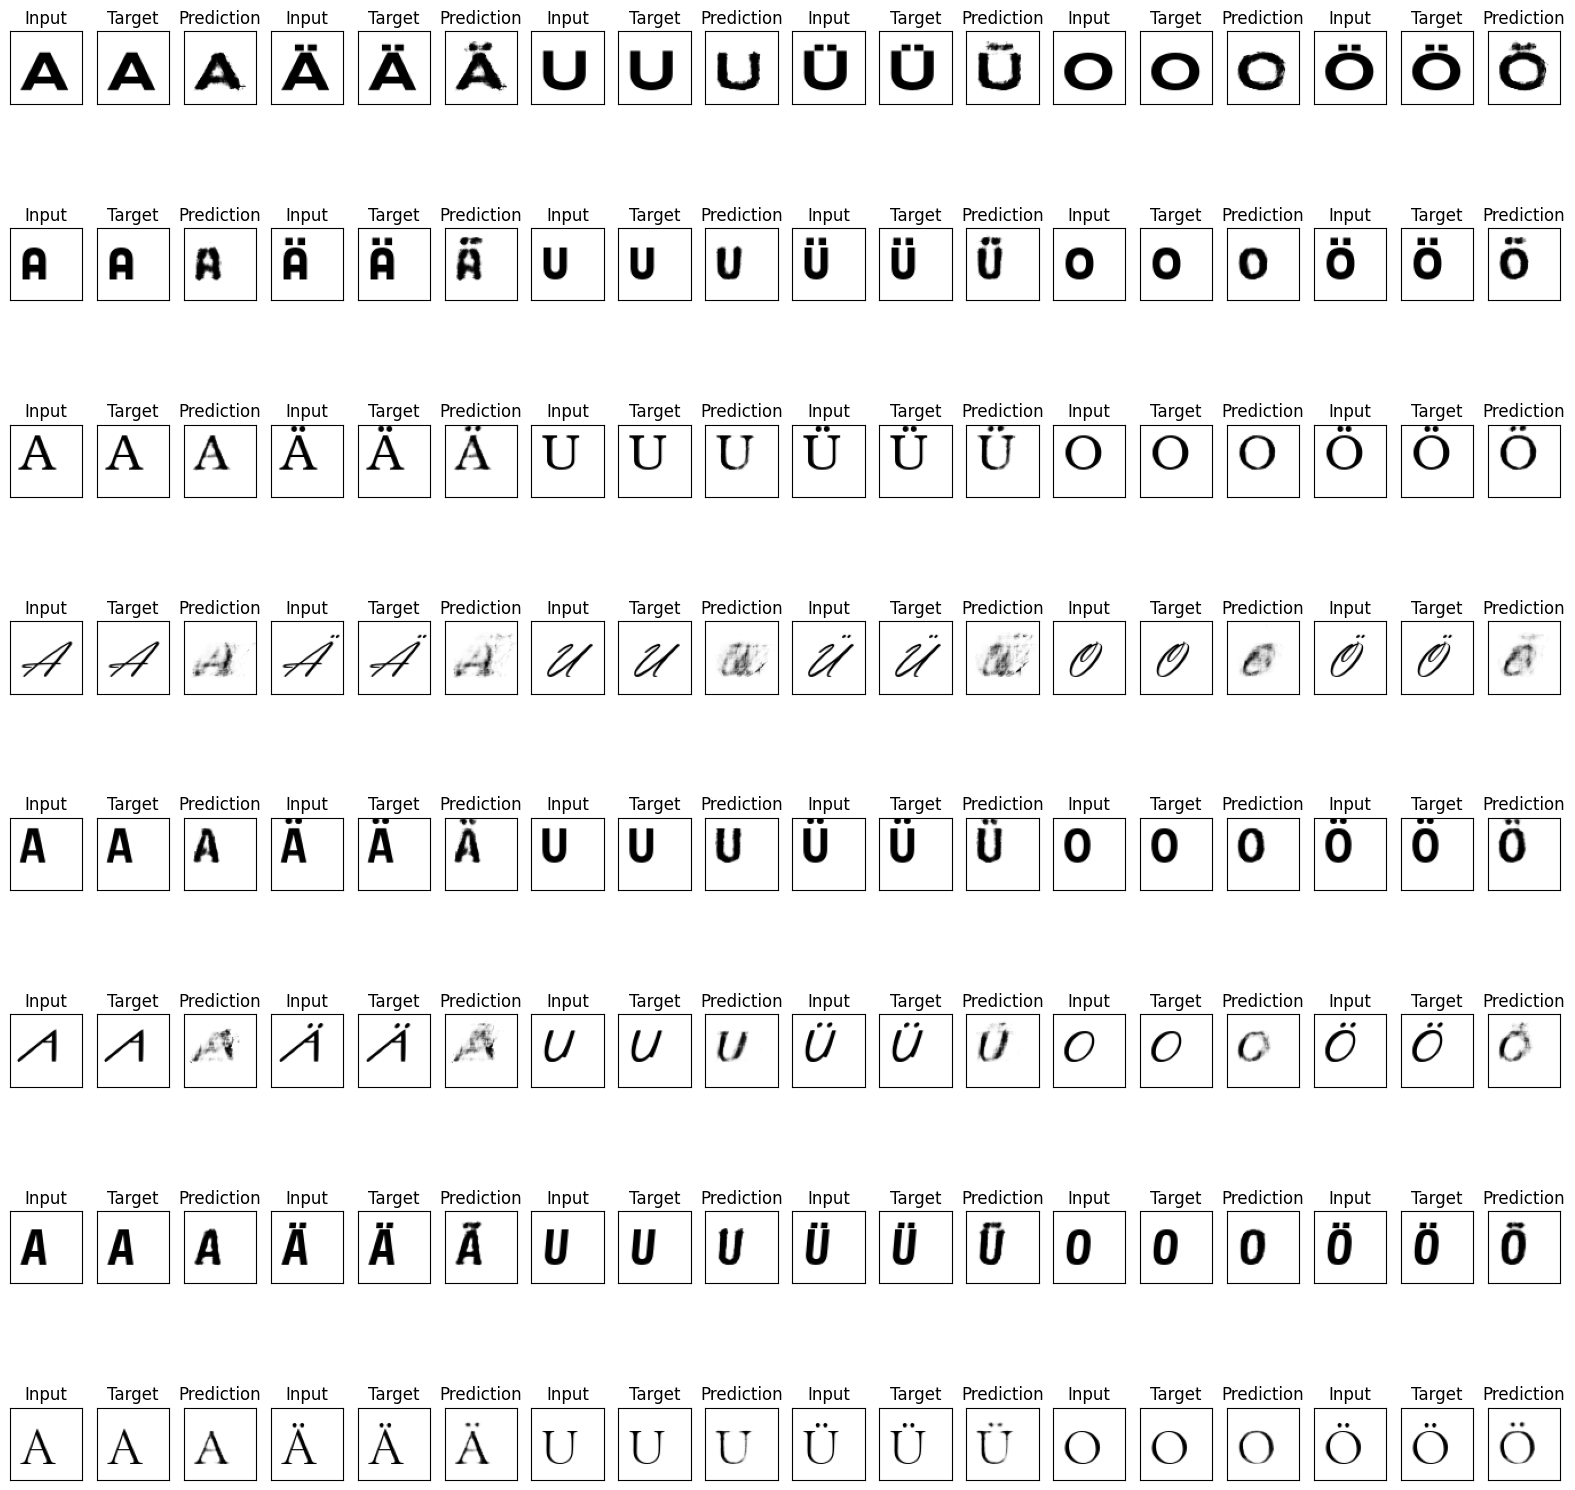

In [77]:
analyze_trainings(trainings_list)
render_predictions(model, dataset_test, num_examples=8, figsize=(20, 20))